In [28]:
import networkx as nx
import pynauty as na
import numpy as np
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import random
import lift as lt
%matplotlib inline

### Multiprocessing for parallel comp

In [3]:
deg = [[1,2,3],[3,4,5]]

In [4]:
def f(a,b,c):
    return a + b + c

f(*deg[1])

12

In [6]:
import multiprocessing as mp
import random 
from functools import partial

lift = lt.Lift("bio-celegansneural", 3)
lift.get_graphlet_count()

with mp.Pool() as p:
    subgraphs = p.map(lift.graph.subgraph, lift.graphlet_samples)
    subgraphs = p.map(nx.Graph, subgraphs)
    method = partial(lt.find_type_match, lift.nx_graphlet_dict, lift.na_graphlet_cert_dict)
    types = p.map(method, subgraphs)
    method = partial(lt.get_degree_list, lift.graph)
    degree_lists = p.map(method, [ e[1] for e in types ])
samples = [
    (e[0], lift.prob_functions[e[0]](*degree_lists[i]))
    for i, e in enumerate(types)
    ]

In [7]:
import pickle
with open('data.pickle', 'wb') as f:    
    pickle.dump(zip(samples, lift.graphlet_samples), f)

In [30]:
import pickle
with open('bio-celegansneural_3_graphletcounts.pickle', 'rb') as f:    
    graphlet_counts = pickle.load(f)
graphlet_counts

{0: 45784, 1: 3166}

### Testing updating counts for bio-celegansneural k >= 5

In [2]:
# Testing doing sequences of liftings
lift = lt.Lift("bio-celegansneural", 5)
diff = 10
NUM_STEPS = 5000
prev_counts = lift.get_graphlet_count(num_steps=NUM_STEPS)
while diff > 5 * 10**(-2):
    current_counts = lift.get_graphlet_count(num_steps=NUM_STEPS)
    diff = (
        np.linalg.norm([
            (prev_counts[key] - current_counts[key])
            for key in prev_counts.keys()])
        / np.linalg.norm([
            prev_counts[key]
            for key in prev_counts.keys()])
        )
    prev_counts = current_counts

print("Samples taken to converge to 5% accuracy:", lift.total_samples)

Samples taken to converge to 5% accuracy: 10000


In [3]:
graphlet_types = [lt.get_graphlet_prob(lift, graphlet)[0] 
                  for graphlet in lift.graphlet_samples]
print(np.bincount(graphlet_types[:NUM_STEPS]))
print(np.bincount(graphlet_types[NUM_STEPS:]))

TypeError: get_graphlet_prob() missing 3 required positional arguments: 'na_graphlet_cert_dict', 'prob_functions', and 'graphlet_nodes'

True counts from ESCAPE. 

- 4-star: 12590985
- 4-path: 6051046
- 5-cycle: 89226
- Hourglass: 154327

Index to name matches:
- 0 - 4-star
- 2 - 4-path
- 7 - 5-cycle
- 10 - hourglass

In [61]:
print(prev_counts[0], prev_counts[2], prev_counts[7], 
      prev_counts[10] )

12243552 6543023 92598 164350


### Testing update counts on a bigger graph: as-caida

In [69]:
# Testing doing sequences of liftings
lift = lt.Lift("as-caida", 3)
diff = 10
NUM_STEPS = 5000
current_counts = lift.get_graphlet_count(num_steps=NUM_STEPS)
while diff > 5 * 10**(-2):
    prev_counts = current_counts
    current_counts = lift.get_graphlet_count(num_steps=NUM_STEPS)
    diff = (
        np.linalg.norm([
            (prev_counts[key] - current_counts[key])
            for key in prev_counts.keys()])
        / np.linalg.norm([
            prev_counts[key]
            for key in prev_counts.keys()])
        )

print("Samples taken to converge to 5% accuracy:", lift.total_samples)

Samples taken to converge to 5% accuracy: 10000


In [74]:
prev_counts

{'triangle': 51162, 'wedge': 13985461}

In [75]:
current_counts

{'triangle': 41832, 'wedge': 14189280}

In [76]:
graphlet_types = [lt.get_graphlet_prob(lift, graphlet)[0] 
                  for graphlet in lift.graphlet_samples]
print(np.bincount(graphlet_types[:NUM_STEPS]))
print(np.bincount(graphlet_types[NUM_STEPS:]))

[4894  106]
[4903   97]


### Testing the index and naming
All is well.

In [4]:
graph = lt.load_graph_fromfile("bio-celegansneural")
lift = lt.Lift(graph, k=5)

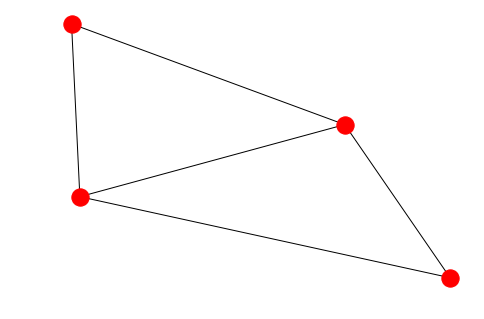

In [22]:
nx.draw(lift.nx_graphlet_dict[4][4])

### Dependence on num_steps for celegans network.

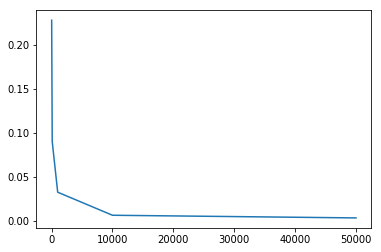

In [65]:
GRAPH = lt.load_graph_fromfile("bio-celegansneural")
K = 3
TRUE_COUNTS = {
    'wedge': 44081,
    'triangle': 3241
}
NUM_RUNS = 10
STEPS = [10, 100, 1000, 10000, 50000]

experiments = [[lt.Lift(GRAPH, K).graphlet_count(num_steps=step)
                for i in range(NUM_RUNS)]
               for step in STEPS]
error_rate = [
    sum(
        [np.linalg.norm(
            [run[key] - TRUE_COUNTS[key] 
             for key in TRUE_COUNTS.keys()]
        ) for run in experiment]
    )
    / num_runs
    / np.linalg.norm(
        [TRUE_COUNTS[key]
         for key in TRUE_COUNTS.keys()])
    for experiment in experiments 
]

plt.plot(STEPS, error_rate)

In [66]:
min_steps = steps[np.min(np.where(np.array(error_rate) < .1))]
print("Minimum steps needed to get 10% accuracy: ",
      min_steps)

Minimum steps needed to get 10% accuracy:  100


In [67]:
print("Speed of the sampling procedure:")
%timeit lt.Lift(GRAPH, K).graphlet_count(num_steps=min_steps)

Speed of the sampling procedure:
186 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
print("Approximately 2ms per sample.")

Approximately 2ms per sample.


### Celegansneural and k=4.

Minimum steps needed to get 10% accuracy:  1000
Speed of the sampling procedure:
421 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


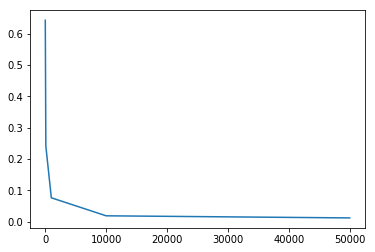

In [71]:
GRAPH = lt.load_graph_fromfile("bio-celegansneural")
K = 4
TRUE_COUNTS = {
    '3-star': 650925,
    '4-path': 516426,
    '4-tailedtriangle': 186292,
    '4-cycle': 15863,
    '4-chordcycle': 22743,
    '4-clique': 2010
}
NUM_RUNS = 10
STEPS = [10, 100, 1000, 10000, 50000]

experiments = [[lt.Lift(GRAPH, K).graphlet_count(num_steps=step)
                for i in range(NUM_RUNS)]
               for step in STEPS]
error_rate = [
    sum(
        [np.linalg.norm(
            [run[key] - TRUE_COUNTS[key] 
             for key in TRUE_COUNTS.keys()]
        ) for run in experiment]
    )
    / num_runs 
    / np.linalg.norm(
        [TRUE_COUNTS[key] 
         for key in TRUE_COUNTS.keys()])
    for experiment in experiments 
]

min_steps = steps[np.min(np.where(np.array(error_rate) < .1))]
print("Minimum steps needed to get 10% accuracy: ",
      min_steps)
print("Speed of the sampling procedure:")
%timeit lt.Lift(GRAPH, K).graphlet_count(num_steps=min_steps)

plt.plot(STEPS, error_rate)

In [72]:
error_rate

[0.6428207469947186,
 0.24166797905598497,
 0.07658217464334786,
 0.019115356904939148,
 0.01238369077437654]

In [ ]:
accurate_num_steps = {
    "bio-celegans": {
        3: 100,
        4: 1000
    }
}

### Here we see a 5x speed gain when doing find_type_match with pynauty over networkx.

In [2]:
num_graphs = 1000
graph_size = 3
random_nx_graphs = [nx.gnp_random_graph(graph_size,0.6) for i in range(num_graphs)]
random_na_graphs = [na.Graph(number_of_vertices = graph_size, directed = False,
                             adjacency_dict = { n: list(nbrdict.keys()) for n, nbrdict in graph.adjacency() }) 
                    for graph in random_nx_graphs]

%time nx_iso = [nx.is_isomorphic(random_nx_graphs[i],random_nx_graphs[j]) 
          for i in range(num_graphs) 
          for j in range(i,num_graphs)]

%time na_iso = [na.certificate(random_na_graphs[i]) == na.certificate(random_na_graphs[j]) 
          for i in range(num_graphs) 
          for j in range(i,num_graphs)]

### Here we show that simply using pynauty to do isomorphism gets a 4x speedup over Kirill's code.

In [3]:
def find_type_match(graph, graphlet_list):
    """
    Given a graph, find an isomorphism with one of the canonical graphs from
    'graphlet_list'.
    Return index of the corresponding graph from 'graphlet_list' and a
    match dictionary.
    The match dictionary has format {u_i: v_i}, 'u_i' are nodes from 'graph'
    and 'v_i' are nodes from canonical graph.
    Helper function for 'prob_functions' for unordered method.
    """
    nodes = graph.nodes()
    n = len(nodes)
    if n == 1:
        # trivial graph: just send it to zero!
        return (0, {u: 0 for u in nodes})
    if n == 2:
        # 2-path graph: both nodes are equal, pick a random isomorphism
        return (0, {u: i for i, u in enumerate(nodes)})
    if n == 3:
        if graph.number_of_edges() == 2:
            # wedge-graph: find root, other two are arbitrary
            u0 = next((node for node in nodes if graph.degree(node) == 2))
            (u1, u2) = (node for node in graph.neighbors(u0))
            return (0, {u0: 0, u1: 1, u2: 2})
        if graph.number_of_edges() == 3:
            # triangle: all three are arbitrary
            return (1, {u: i for i, u in enumerate(nodes)})
    if n == 4:
        e_num = graph.number_of_edges()
        max_degree = max((graph.degree(node) for node in nodes))
        if e_num == 3 and max_degree == 3:
            u3 = next((node for node in nodes if graph.degree(node) == 3))
            (u0, u1, u2) = tuple(graph.neighbors(u3))
            return (0, {u0: 0, u1: 1, u2: 2, u3: 3})
        if e_num == 3 and max_degree == 2:
            (u0, u1) = (node for node in nodes if graph.degree(node) == 2)
            u2 = next((node for node in graph.neighbors(u1) if node != u0))
            u3 = next((node for node in graph.neighbors(u0) if node != u1))
            return (1, {u0: 0, u1: 1, u2: 2, u3: 3})
        if e_num == 4 and max_degree == 3:
            u3 = next((node for node in nodes if graph.degree(node) == 3))
            (u1, u2) = (node for node in nodes if graph.degree(node) == 2)
            u0 = next((node for node in nodes if graph.degree(node) == 1))
            return (2, {u0: 0, u1: 1, u2: 2, u3: 3})
        if e_num == 4 and max_degree == 2:
            u0 = next((node for node in nodes))
            (u1, u3) = tuple(graph.neighbors(u0))
            u2 = next((node for node in graph.neighbors(u1) if node != u0))
            return (3, {u0: 0, u1: 1, u2: 2, u3: 3})
        if e_num == 5:
            (u0, u2) = (node for node in nodes if graph.degree(node) == 3)
            (u1, u3) = (node for node in nodes if graph.degree(node) == 2)
            return (4, {u0: 0, u1: 1, u2: 2, u3: 3})
        if e_num == 6:
            (u0, u1, u2, u3) = tuple(nodes)
            return (5, {u0: 0, u1: 1, u2: 2, u3: 3})
        raise ValueError("wrong graphlet format")

    # Improve matching procedure here for n>4.
    for (i, graph_) in enumerate(graphlet_list):
        graph_matcher = iso.GraphMatcher(graph, graph_)
        if graph_matcher.is_isomorphic():
            break
    #assert graph_id[1].is_isomorphic()
    return (i, graph_matcher.mapping)

def get_graphlet_list(k):
    """
    Generate list of all graphlets of size 'k'.
    List is taken from graph_atlas of networkx.
    """
    from networkx.generators.atlas import graph_atlas_g
    assert k > 0
    atlas = graph_atlas_g()[1:]
    graphlet_list = []
    for graph in atlas:
        n = graph.number_of_nodes()
        if n < k:
            continue
        if n > k:
            break
        if nx.is_connected(graph):
            graphlet_list.append(graph)
    return graphlet_list

def nxgraph_to_nagraph(nxgraph):
    return na.Graph(number_of_vertices = graphlet_size, 
                    directed = False,
                    adjacency_dict = { n: list(nbrdict.keys()) 
                                       for n, nbrdict in nxgraph.adjacency() }
                    )

def find_type_match2(graph, na_graphlet_list, nx_graphlet_list):
    import networkx.algorithms.isomorphism as iso
    
    for i, graph2 in enumerate(na_graphlet_list):
        if na.certificate(graph) == na.certificate(graph2):
            break
    
    G1 = nx.from_dict_of_lists(graph.adjacency_dict)
    G2 = nx_graphlet_list[i]
    matcher = iso.GraphMatcher(G1, G2)
    mapping = next(matcher.match())
    return (i, mapping)

In [117]:
graphlet_size = 5
nx_graphlet_list = get_graphlet_list(graphlet_size)
na_graphlet_list = [ nxgraph_to_nagraph(graph) for graph in nx_graphlet_list ]
num_graphs = 500
random_nx_graphs = [ random.choice(nx_graphlet_list) for i in range(num_graphs) ]
random_na_graphs = [ nxgraph_to_nagraph(graph) for graph in random_nx_graphs ]

In [118]:
%%time
nx_types = [ find_type_match(graph, nx_graphlet_list) for graph in random_nx_graphs ]

CPU times: user 489 ms, sys: 8.57 ms, total: 498 ms
Wall time: 532 ms


In [119]:
%%time
na_types = [ find_type_match2(graph, na_graphlet_list, nx_graphlet_list) for graph in random_na_graphs ]

CPU times: user 267 ms, sys: 5.12 ms, total: 272 ms
Wall time: 292 ms


In [97]:
for i, graph2 in enumerate(na_graphlet_list):
    if na.certificate(random_na_graphs[0]) == na.certificate(graph2):
        break
G1 = nx.from_dict_of_lists(random_na_graphs[0].adjacency_dict)
G2 = nx_graphlet_list[i]
find_type_match2(random_na_graphs[0], na_graphlet_list, nx_graphlet_list)
print(iso.is_isomorphic(G1, G2))

True


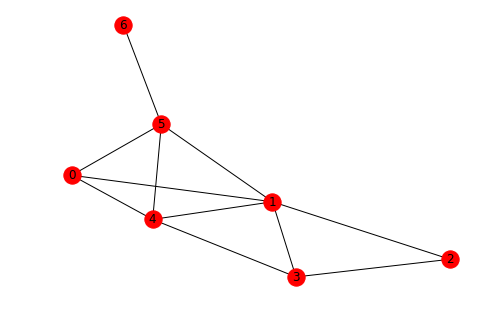

In [98]:
nx.draw(G1,with_labels=True)

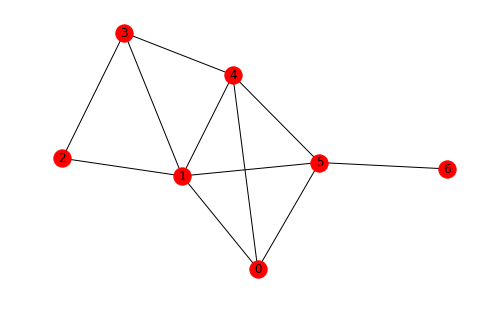

In [99]:
nx.draw(G2,with_labels=True)

# Test NetworkX subgraphing vs Kirill's code.
NetworkX is faster.

In [18]:
def get_subgraph(graph, nodes):
    """
    Manually constructs the induced subgraph given a list of nodes from the full graph.
    Returns a new networkx graph object.
    Helper function for shotgun method and probability functions in the unordered method.

    NOTE:
        We use this because the networkx subgraph method is very slow.
    """
    list_nodes = list(nodes)
    subgraph = nx.Graph()
    subgraph.add_nodes_from(nodes)
    for i, node in enumerate(list_nodes):
        neighbors = list(graph.neighbors(node))
        for j in range(i+1, len(list_nodes)):
            if list_nodes[j] in neighbors:
                subgraph.add_edge(node, list_nodes[j])
    return subgraph

graph = lt.load_graph_fromfile("bio-celegansneural")

n = 100
k = 5
lift_unordered = lt.Lift(graph,k)
vertex_sets = [lift_unordered.sample_unordered_lift(lt.sample_vertex(graph))
               for j in range(n)]

nx_subg = [nx.to_dict_of_dicts(graph.subgraph(vertex_set)) 
           for vertex_set in vertex_sets]
k_subg = [nx.to_dict_of_dicts(get_subgraph(graph, vertex_set)) 
          for vertex_set in vertex_sets]

print("Are methods equal?", all([ nx_subg[i] == k_subg[i] for i in range(n) ]))

graph = lt.load_graph_fromfile("bio-celegansneural")

n = 20
k = 5
lift_unordered = lt.Lift(graph,k)
vertex_sets = [lift_unordered.sample_unordered_lift(lt.sample_vertex(graph))
               for j in range(n)]

print("bio-celegansneural")
print("NetworkX performance:")
%timeit nx_subg = [ graph.subgraph(vertex_set) for vertex_set in vertex_sets ]
print("Kirill performance:")
%timeit k_subg = [ get_subgraph(graph, vertex_set) for vertex_set in vertex_sets ]

graph = lt.load_graph_fromfile("misc-polblogs")

n = 20
k = 5
lift_unordered = lt.Lift(graph,k)
vertex_sets = [lift_unordered.sample_unordered_lift(lt.sample_vertex(graph))
               for j in range(n)]

print("misc-polblogs")
print("NetworkX performance:")
%timeit nx_subg = [ graph.subgraph(vertex_set) for vertex_set in vertex_sets ]
print("Kirill performance:")
%timeit k_subg = [ get_subgraph(graph, vertex_set) for vertex_set in vertex_sets ]

Are methods equal? True
bio-celegansneural
NetworkX performance:
222 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Kirill performance:
580 µs ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
misc-polblogs
NetworkX performance:
256 µs ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Kirill performance:
1.04 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
